In [ ]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu MHz		: 2200.180
cpu cores	: 1
# RAM
MemTotal:       13290460 kB
# GPU

# OS
Linux 079fb98bb770 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
pip install --upgrade keras-hub

In [ ]:
# @title Default title text
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras

from keras import losses, optimizers
import keras_hub
from keras_hub.models import BertTextClassifier

import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflo

2.18.0


## 1. Load and preprocess the dataset

In [ ]:
!git clone https://github.com/taivop/joke-dataset.git /content/reddit_jokes

fatal: destination path '/content/reddit_jokes' already exists and is not an empty directory.


In [ ]:
df = pd.read_json('/content/reddit_jokes/reddit_jokes.json')
df["input_text"] = df["title"] + " " + df["body"]
#loaded and combined the text part of data


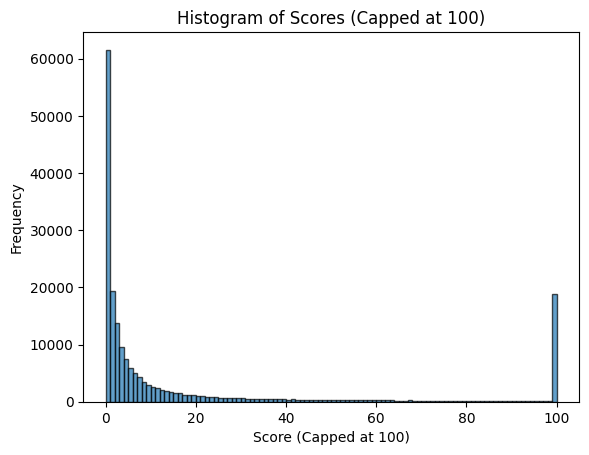

In [ ]:

df['score_capped'] = df['score'].clip(upper=100)  # Limit scores to 100

# Create histogram
plt.hist(df['score_capped'], bins=100, edgecolor='k', alpha=0.7)
plt.xlabel('Score (Capped at 100)')
plt.ylabel('Frequency')
plt.title('Histogram of Scores (Capped at 100)')
plt.show()




In [ ]:
def map_score_to_label(score):
    if score == 0:
        return 0
    #elif 1 <= score <= 10:
     #   return 1
    else:
        return 1


df['label'] = df['score'].apply(map_score_to_label)

#Due to oyur imbalenced dataset, we will simply see if our model can predict if it was "popular" (meaning had a non-zero score) or not
#Our target is now a binary of it it had a non-zero score or not

Construct a balanced dataset

In [ ]:

def generate_balanced_sets(df, label_column="label", train_ratio=0.8):
    """
    Generate balanced training and testing sets from a DataFrame for arbitrary number of labels.

    Parameters:
        df (pd.DataFrame): Input DataFrame with features and a label column.
        label_column (str): Name of the column containing labels.
        train_ratio (float): Proportion of data to use for training.

    Returns:
        train_df (pd.DataFrame): DataFrame containing training data.
        test_df (pd.DataFrame): DataFrame containing testing data.
    """
    # Split the DataFrame by label
    unique_labels = df[label_column].unique()
    train_frames = []
    test_frames = []

    for label in unique_labels:
        # Filter data for the current label
        label_df = df[df[label_column] == label]

        # Shuffle the data
        label_df = label_df.sample(frac=1, random_state=42).reset_index(drop=True)

        # Determine the split sizes
        train_size = int(train_ratio * len(label_df))

        # Split into training and testing
        train_frames.append(label_df.iloc[:train_size])
        test_frames.append(label_df.iloc[train_size:])

    # Concatenate training and testing DataFrames
    train_df = pd.concat(train_frames).sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = pd.concat(test_frames).sample(frac=1, random_state=42).reset_index(drop=True)

    return train_df, test_df



df_train, df_test =  generate_balanced_sets(df, train_ratio=0.8)
display(df_train.head(3))

,body,id,score,title,input_text,score_capped,label
0,Captain Cook.,4ucfpd,2,Which pirate makes the best food?,Which pirate makes the best food? Captain Cook.,2,1
1,"I really can't stay\n(But baby, it's cold outs...",2oovwy,0,"Baby, It's Cold Outside - The Cosby Version","Baby, It's Cold Outside - The Cosby Version I ...",0,0
2,Punch her in the face. \n,3ajax9,7,What do you do when your dishwasher stops work...,What do you do when your dishwasher stops work...,7,1


## 2. Create model



In [ ]:


# Initialize pretrained classifier
classifier = BertTextClassifier.from_preset(
    "bert_base_en_uncased",    num_classes=2) # 3 classes as defined in the label mapping





In [ ]:
# Extract features and labels
features = df_train["input_text"].tolist()[:200]  # List of text features
labels = df_train['label'].tolist()[:200]  # List of labels

# First training
classifier.fit(x=features, y=labels, batch_size=2)

# Predict using the trained classifier
predictions = classifier.predict(x=features, batch_size=2)
print(predictions)

# Re-compile with a new learning rate
# classifier.compile(
#     loss=losses.SparseCategoricalCrossentropy(from_logits=False),
#     optimizer=optimizers.Adam(5e-5),
#     jit_compile=True,
# )

# Set backbone to non-trainable
#classifier.backbone.trainable = False

# Fit again
#classifier.fit(x=features, y=labels, batch_size=2)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1527s 15s/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7062
100/100 ━━━━━━━━━━━━━━━━━━━━ 450s 4s/step
[[-0.39899492  0.54112065]
 [-0.38360602  0.5120296 ]
 [-0.41477513  0.55101347]
 [-0.38228318  0.5512826 ]
 [-0.36217657  0.5030251 ]
 [-0.40964115  0.54838926]
 [-0.4297817   0.50436544]
 [-0.28952742  0.4333109 ]
 [-0.37972233  0.5185992 ]
 [-0.33660638  0.4881015 ]
 [-0.40613285  0.57245845]
 [-0.46327364  0.58656895]
 [-0.39396966  0.5209283 ]
 [-0.39425495  0.5233726 ]
 [-0.43758628  0.58498085]
 [-0.41817594  0.56016743]
 [-0.42599195  0.577678  ]
 [-0.34827873  0.48538196]
 [-0.34166843  0.48621163]
 [-0.44246265  0.56968087]
 [-0.40476605  0.575062  ]
 [-0.39476135  0.48584917]
 [-0.41388088  0.55057734]
 [-0.4144645   0.57918733]
 [-0.40252402  0.55604476]
 [-0.38664025  0.51640695]
 [-0.41252062  0.55114555]
 [-0.42088917  0.5389321 ]
 [-0.3753799   0.5403042 ]
 [-0.42213506  0.55400896]
 [-0.37910977  0.5172662 ]
 [-0.43276873  0.5577272

In [ ]:
x_test = df_test['input_text'].tolist()[:200]  # List of text features
y_test = df_test['label'].tolist()[:200]
classifier.evaluate(x_test, y_test,batch_size=32)

7/7 ━━━━━━━━━━━━━━━━━━━━ 514s 72s/step - loss: 0.6377 - sparse_categorical_accuracy: 0.6691


[0.632301926612854, 0.675000011920929]

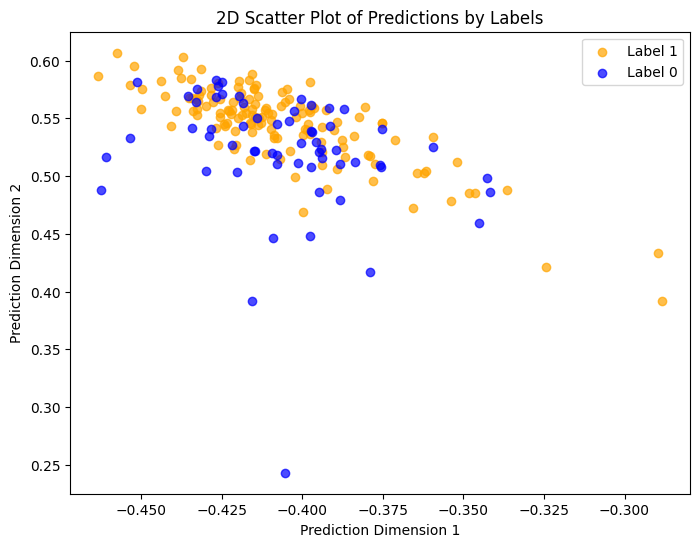

In [ ]:
# Split predictions by label

labels_array = np.array(labels)
predictions_label_0 = predictions[labels_array == 0]
predictions_label_1 = predictions[labels_array == 1]

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Plot for labels=1
plt.scatter(predictions_label_1[:, 0], predictions_label_1[:, 1], color='orange', label='Label 1', alpha=0.7)

# Plot for labels=0
plt.scatter(predictions_label_0[:, 0], predictions_label_0[:, 1], color='blue', label='Label 0', alpha=0.7)



# Add labels, legend, and title
plt.title('2D Scatter Plot of Predictions by Labels')
plt.xlabel('Prediction Dimension 1')
plt.ylabel('Prediction Dimension 2')
plt.legend()

# Show the plot
plt.show()